<a href="https://colab.research.google.com/github/Mohamed-mahi/VerletDiffusionSim/blob/main/updated_trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class PES:
    def __init__(self, C0_min, C1_min, C2_min, C0_max, C1_max, C2_max, lattice_constant):
        self.Delta_0 = C0_max - C0_min
        self.Delta_1 = C1_max - C1_min
        self.Delta_2 = C2_max - C2_min
        self.C0_max = C0_max
        self.C1_max = C1_max
        self.C2_max = C2_max
        self.lattice_constant = lattice_constant

    def u(self, x, y):
        theta_x = 2. * np.pi * x / self.lattice_constant
        theta_y = 2. * np.pi * y / (self.lattice_constant * np.sqrt(3.))
        return 2.*(3. - 2. * np.cos(theta_x) * np.cos(theta_y) - np.cos(2. * theta_y))/9.

    def V(self, x, y, z):
        u_ = self.u(x, y)
        C0 = self.C0_max - self.Delta_0 * u_
        C1 = self.C1_max - self.Delta_1 * u_
        C2 = self.C2_max - self.Delta_2 * u_
        return C0 * np.exp(-z * C1) - C2 / (z**4)

    def force(self, x, y, z, h=1.e-6):
        energy = self.V(x, y, z)
        dV_dx = (self.V(x + h, y, z) - self.V(x - h, y, z)) / (2. * h)
        dV_dy = (self.V(x, y + h, z) - self.V(x, y - h, z)) / (2. * h)
        dV_dz = (self.V(x, y, z + h) - self.V(x, y, z - h)) / (2. * h)
        return -dV_dx,-dV_dy, -dV_dz

    def calculate_multiple(self, xs, ys, zs):
        energies = np.zeros((len(int(xs)), len(int(ys))))
        forces_x = np.zeros(len((int(xs)), len(int(ys))))
        forces_y = np.zeros(len((int(xs)), len(int(ys))))
        forces_z = np.zeros(len((int(xs)), len(int(ys))))

        for i in range(len(int(xs))):
            for j in range(len(int(ys))):
                energies[i, j] = self.V(xs[i], ys[j], zs)
                Fx, Fy, Fz = self.force(xs[i], ys[j], zs)
                forces_x[i, j] = Fx
                forces_y[i, j] = Fy
                forces_z[i, j] = Fz

        return energies, forces_x, forces_y, forces_z

In [ ]:
def force(x, y, z):
        # given parameters
    C0_min = 1.63093e6
    C1_min = 3.347616
    C2_min = 8184.70
    C0_max = 2.75075e6
    C1_max = 3.349208
    C2_max = 8258.11
    lattice_constant = 2.462
    z = 3.2
    # Initialize the PES object
    MOHAMMED = PES(C0_min, C1_min, C2_min, C0_max, C1_max, C2_max, lattice_constant)

    # Calculate energies and force components
    fx, fy, fz = MOHAMMED.force(x, y, z)
    energy = MOHAMMED.V(x,y,z)
    return energy, fx, fy, fz

def write(xt, yt, zt, vxt, vyt, vzt, forcex, forcey, forcez, energy, particle_id):
    pass  # avoiding printing values

def simulate_particle(particle_id, nsteps, dt, gamma, temp, mass, initial_variance):
    hdt = 0.5 * dt
    varg = np.sqrt(2. * gamma * temp * hdt / mass)
    random = np.random.default_rng()

    # Initial conditions
    xt, yt, zt = 0.0, 0.0, 0.0
    vxt, vyt, vzt = 0.0, 0.0, 0.0

    # Forces and potential energy of the particle at the initial time
    energy, forcex, forcey, forcez = force(xt, yt, zt)

    # Memorize values at time step 0
    write(xt, yt, zt, vxt, vyt, vzt, forcex, forcey, forcez, energy, particle_id)

    # Lists to store trajectory
    traj_x = [xt]
    traj_y = [yt]
    traj_z = [zt]
    traj_e = [energy]

    for k in range(nsteps):
        # First step in velocity Verlet: v(t + dt/2) = v(t) + f(t)/m * dt/2
        vxt += random.normal(0., varg) - gamma * hdt * vxt + hdt * forcex / mass
        vyt += random.normal(0., varg) - gamma * hdt * vyt + hdt * forcey / mass
        vzt += random.normal(0., varg) - gamma * hdt * vzt + hdt * forcez / mass


        # Second step in velocity Verlet: r(t + dt) = r(t) + v(t + dt/2) * dt
        xt += dt * vxt
        yt += dt * vyt
        zt += dt * vzt


        # Potential energy and forces at time t + dt
        energy, forcex, forcey, forcez = force(xt, yt, zt)

        # Third step in velocity Verlet: v(t + dt) = v(t + dt/2) + f(t + dt)/m * dt/2
        vxt += random.normal(0., varg) - gamma * hdt * vxt + hdt * forcex / mass
        vyt += random.normal(0., varg) - gamma * hdt * vyt + hdt * forcey / mass
        vzt += random.normal(0., varg) - gamma * hdt * vzt + hdt * forcez / mass


        # Memorize values at time step k
        write(xt, yt, zt, vxt, vyt, vzt, forcex, forcey, forcez, energy, particle_id)

        # Store trajectory
        traj_x.append(xt)
        traj_y.append(yt)
        traj_z.append(zt)
        traj_e.append(energy)



    return traj_x, traj_y, traj_z, traj_e

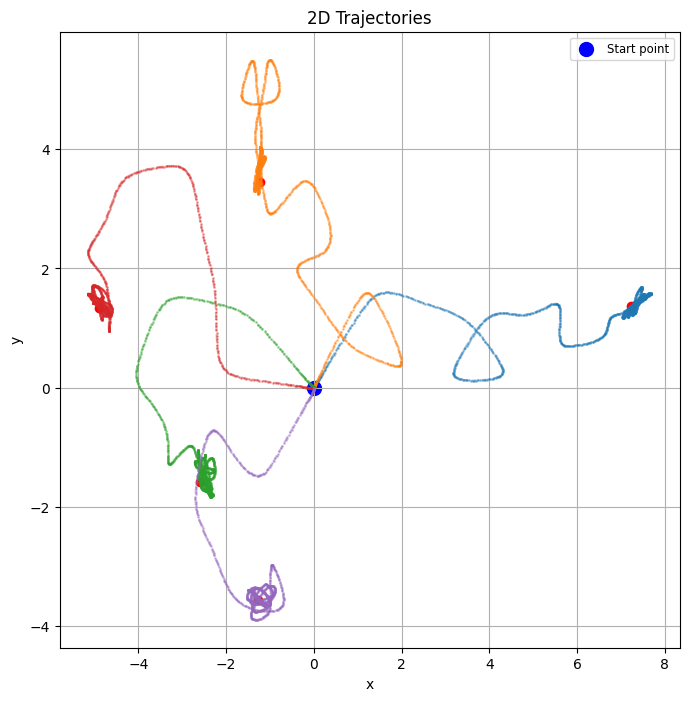

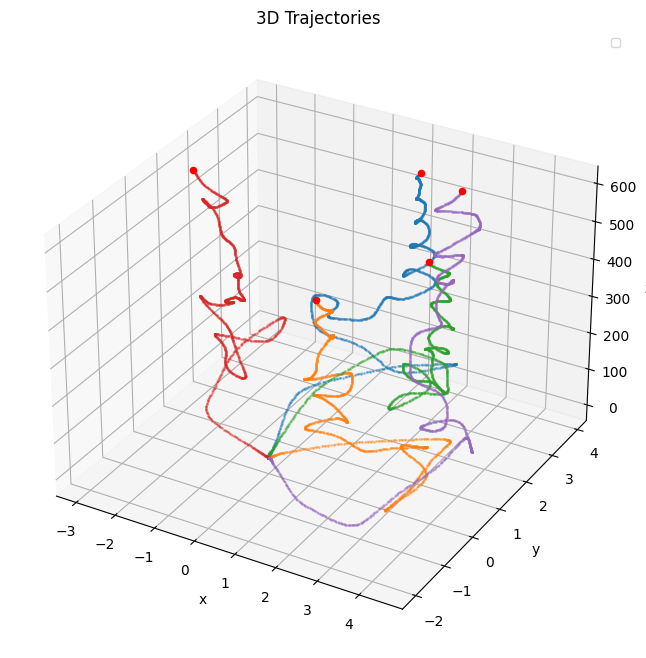

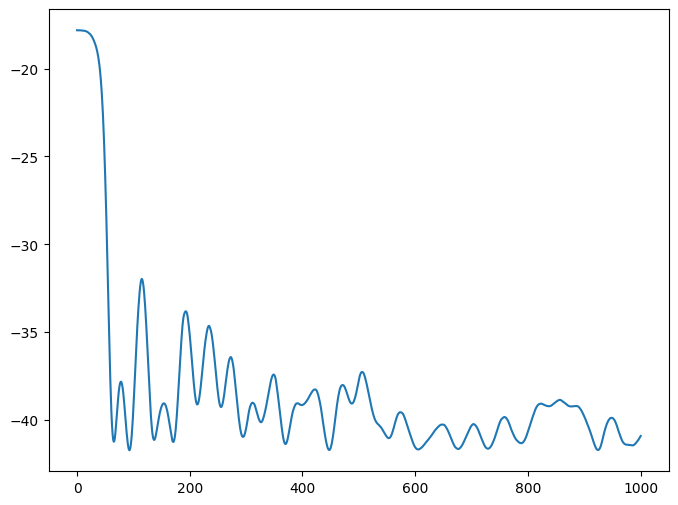

In [ ]:
if __name__ == "__main__":
    dt = 0.01
    gamma = 0.5
    temp = 0.5
    mass = 1.0
    nsteps = 1000
    num_particles = 5
    initial_variance = 0.05  # variance for initial random velocity perturbations

    fig, ax = plt.subplots(figsize=(8, 8))

    for i in range(num_particles):
        traj_x, traj_y,traj_z,traj_e = simulate_particle(i, nsteps, dt, gamma, temp, mass, initial_variance)
        ax.plot(traj_x, traj_y, linestyle='--', marker='o', markersize=1, alpha=0.4)
        ax.scatter(traj_x[-1], traj_y[-1], c='red', marker='o')  # End point

    ax.scatter(0, 0, c='blue', marker='o', s=100, label='Start point') # start point

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('2D Trajectories')
    ax.grid(True)
    ax.legend(loc='upper right', fontsize='small')

    plt.show()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_particles):
        traj_x, traj_y, traj_z, traj_e = simulate_particle(i, nsteps, dt, gamma, temp, mass, initial_variance)
        ax.plot(traj_x, traj_y, traj_z, linestyle='--', marker='o', markersize=1, alpha=0.4)
        ax.scatter(traj_x[-1], traj_y[-1], traj_z[-1], c='red', marker='o')  # End point

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('3D Trajectories')
    ax.grid(True)
    ax.legend(loc='upper right', fontsize='small')

    plt.show()

    fig2, ax2 = plt.subplots(figsize=(8, 6))
    ax2.plot(traj_e) # start point
    plt.show()